# TO-DO

Pull code from GitHub (Eva's pushed code)

## Create Visualizations

The code below creates a sample reply tree and reply graph visualization and saves them to two files. This is okay, but we should update the visualizations to be prettier (they should be added to the report).

The updates that should be made are the following:
- For the reply tree, we should remove the labels that are added within the circles of the nodes (tweet id). These do not add information that is useful to have. We should add some color to the tree (e.g., node color, edge color, root node different background color?)
- For the reply graph, current visualizations are way too dense and the edges are unorganized. Look at the slides from Week 4 for examples how the visualizations should look. We should make this much prettier.

Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt', reply_tweets='congress_df_2022-10-26_reply_tweets.txt', reply_mappings='congress_df_2022-10-26_reply_mappings.txt')
1637 1637


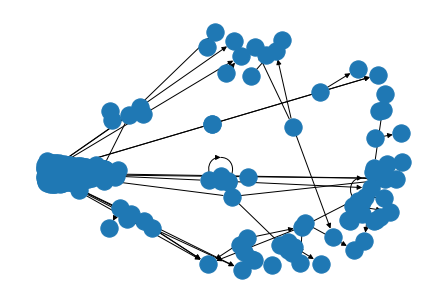

In [1]:
%run create_visualizations.py --initial_tweets congress_df_2022-10-26_tweets.txt --reply_tweets congress_df_2022-10-26_reply_tweets.txt --reply_mappings congress_df_2022-10-26_reply_mappings.txt 

## Create DataFrame with ML Features

First, play around to compute some features. Then, make it modular and put it in original code.

Democrats tend to tweet more than republicans; democrats tend to have more followers than republicans; democrats tend to follow more people than republicans

### Import Packages

In [125]:
import ast
import create_reply_trees as crt
import numpy as np
import pandas as pd
import networkx
import treelib
import json
import math
import matplotlib.pyplot as plt

### Get tree and graph dictionaries to play around with

In [2]:
from argparse import Namespace

flags = Namespace(initial_tweets='congress_df_2022-10-26_tweets.txt',
                  reply_tweets='congress_df_2022-10-26_reply_tweets.txt',
                  reply_mappings='congress_df_2022-10-26_reply_mappings.txt'
                  )

In [3]:
cid_tree_dict, cid_graph_dict = crt.create_reply_trees_and_graphs(
        flags.reply_tweets, flags.initial_tweets, flags.reply_mappings
    )

Number of reply cids found: 1439
Length of cid_tree_dict: 1630, length of cid_graph_dict: 1630
Built mapping dictionaries.
Added nodes to trees and graphs.
Rerordered trees.
Added graph edges.


### Initialize DataFrame

In [40]:
conv_df = pd.DataFrame(index=cid_tree_dict.keys())

In [41]:
conv_df['tree_size'] = np.zeros(len(conv_df))
conv_df['tree_depth'] = np.zeros(len(conv_df))
conv_df['tree_lvl1_breadth'] = np.zeros(len(conv_df))
conv_df['tree_breadth'] = np.zeros(len(conv_df))
conv_df['tree_out_degree_avg'] = np.zeros(len(conv_df))
conv_df['tree_max_replies_exc_orig'] = np.zeros(len(conv_df))
conv_df['tree_dropped_node_count'] = np.zeros(len(conv_df))

conv_df['orig_retweet_count'] = np.zeros(len(conv_df))
conv_df['orig_like_count'] = np.zeros(len(conv_df))
conv_df['orig_quote_count'] = np.zeros(len(conv_df))

### Compute Tree Features

In [42]:
for cid, tree in cid_tree_dict.items():
    # Basic metrics
    conv_df['tree_size'][cid] = tree.size()
    conv_df['tree_depth'][cid] = tree.depth()
    conv_df['tree_lvl1_breadth'][cid] = tree.size(level=1)
    conv_df['tree_breadth'][cid] = len(tree.leaves())
    
    # Calculation metrics
    out_degree = 0
    max_children = 0
    for node in tree.all_nodes():
        out_degree += len(tree.children(node.tag))
        if node.is_root() == False and len(tree.children(node.tag)) > max_children:
            max_children = len(tree.children(node.tag))
            
    conv_df['tree_out_degree_avg'][cid] = out_degree/tree.size()
    conv_df['tree_max_replies_exc_orig'][cid] = max_children
    
    # Use data in tree to define metrics
    conv_df['tree_dropped_node_count'][cid] = tree[tree.root].data['dropped_node_count']
    conv_df['orig_retweet_count'][cid] = tree[tree.root].data['retweet_count']
    conv_df['orig_like_count'][cid] = tree[tree.root].data['like_count']
    conv_df['orig_quote_count'][cid] = tree[tree.root].data['quote_count']

### Compute Graph Features

In [43]:
conv_df['graph_user_count'] = np.zeros(len(conv_df))
conv_df['graph_edge_per_user_count'] = np.zeros(len(conv_df))
conv_df['graph_in_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_out_degree_author'] = np.zeros(len(conv_df))
conv_df['graph_avg_out_degree'] = np.zeros(len(conv_df)) # you reply
conv_df['graph_avg_in_degree'] = np.zeros(len(conv_df)) # replies to you

conv_df['graph_nr_conn_comp'] = np.zeros(len(conv_df))
conv_df['graph_max_degree_exc_orig'] = np.zeros(len(conv_df))
conv_df['graph_reciprocity'] = np.zeros(len(conv_df))
conv_df['graph_density'] = np.zeros(len(conv_df))

conv_df['graph_degree_assortativity'] = np.zeros(len(conv_df))
conv_df['graph_dropped_node_count'] = np.zeros(len(conv_df))
conv_df['graph_dropped_edge_count'] = np.zeros(len(conv_df))

conv_df['graph_author_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_author_following_count'] = np.zeros(len(conv_df))
conv_df['graph_author_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_author_listed_count'] = np.zeros(len(conv_df))

conv_df['graph_avg_user_follower_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_following_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_tweet_count'] = np.zeros(len(conv_df))
conv_df['graph_avg_user_listed_count'] = np.zeros(len(conv_df))
conv_df['graph_user_verified_frac'] = np.zeros(len(conv_df))

conv_df['graph_follower_assortativity'] = np.zeros(len(conv_df))

In [44]:
i = 0
for cid, graph in cid_graph_dict.items():
    conv_df['graph_user_count'][cid] = graph.number_of_nodes()
    conv_df['graph_edge_per_user_count'][cid] = graph.number_of_edges()/graph.number_of_nodes()
    
    tree = cid_tree_dict[cid]
    orig_author_id = tree[tree.root].data['author_id']
    
    conv_df['graph_in_degree_author'][cid] = graph.in_degree(orig_author_id)
    conv_df['graph_out_degree_author'][cid] = graph.out_degree(orig_author_id)
    
    conv_df['graph_avg_out_degree'][cid] = np.mean([deg for (node, deg) in graph.out_degree()])
    conv_df['graph_avg_in_degree'][cid] = np.mean([deg for (node, deg) in graph.in_degree()])
        
    graph_und = graph.to_undirected()
    conv_df['graph_nr_conn_comp'][cid] = networkx.number_connected_components(graph_und)
    
    try:
        conv_df['graph_max_degree_exc_orig'][cid] = max([deg for (node, deg) in graph.degree() if node!=orig_author_id])
    except:
        pass
    
    try:
        conv_df['graph_reciprocity'][cid] = networkx.reciprocity(graph)
    except:
        pass
    
    conv_df['graph_density'][cid] = networkx.density(graph)
    
    if np.isnan(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif math.isinf(networkx.degree_assortativity_coefficient(graph)):
        conv_df['graph_degree_assortativity'][cid] = 0
    elif networkx.degree_assortativity_coefficient(graph) in (None, ''):
        conv_df['graph_degree_assortativity'][cid] = 0
    else:
        conv_df['graph_degree_assortativity'][cid] = networkx.degree_assortativity_coefficient(graph)
        
    conv_df['graph_dropped_node_count'][cid] = graph.graph['dropped_node_count']
    conv_df['graph_dropped_edge_count'][cid] = graph.graph['dropped_edge_count']
    
    graph.nodes[orig_author_id]['follower_attr'] = graph.nodes[orig_author_id]['public_metrics']['followers_count']
    graph.nodes[orig_author_id]['following_attr'] = graph.nodes[orig_author_id]['public_metrics']['following_count']
    graph.nodes[orig_author_id]['tweet_attr'] = graph.nodes[orig_author_id]['public_metrics']['tweet_count']
    
    conv_df['graph_author_follower_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['followers_count']
    conv_df['graph_author_following_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['following_count']
    conv_df['graph_author_tweet_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['tweet_count']
    conv_df['graph_author_listed_count'][cid] = graph.nodes[orig_author_id]['public_metrics']['listed_count']
    
    user_follower_count = 0
    user_following_count = 0
    user_tweet_count = 0
    user_listed_count = 0
    user_verified_count = 0
    
    for node in graph.nodes:
        if node != orig_author_id:
            try:
                user_metrics = graph.nodes[node]['public_metrics']
                user_follower_count += user_metrics['followers_count']
                user_following_count += user_metrics['following_count']
                user_tweet_count += user_metrics['tweet_count']
                user_listed_count += user_metrics['listed_count']
                user_verified_count += 1 if graph.nodes[node]['verified']==True else 0 
                
                graph.nodes[node]['follower_attr'] = user_metrics['followers_count']
                graph.nodes[node]['following_attr'] = user_metrics['following_count']
                graph.nodes[node]['tweet_attr'] = user_metrics['tweet_count']
            except:
                graph.nodes[node]['follower_attr'] = 0
                graph.nodes[node]['following_attr'] = 0
                graph.nodes[node]['tweet_attr'] = 0
                #pass
        
    if graph.number_of_nodes() != 1:
        conv_df['graph_avg_user_follower_count'][cid] = user_follower_count/graph.number_of_nodes()
        conv_df['graph_avg_user_following_count'][cid] = user_following_count/graph.number_of_nodes()
        conv_df['graph_avg_user_tweet_count'][cid] = user_tweet_count/graph.number_of_nodes()
        conv_df['graph_avg_user_listed_count'][cid] = user_listed_count/graph.number_of_nodes()
    conv_df['graph_user_verified_frac'][cid] = (user_verified_count+1)/graph.number_of_nodes() # all congress members are verified
    
    # Add assortativity for follower count, following count, and tweet count
    conv_df['graph_follower_assortativity'][cid] = networkx.attribute_assortativity_coefficient(graph, 'follower_attr')
    if np.isnan(conv_df['graph_follower_assortativity'][cid]):
        conv_df['graph_follower_assortativity'][cid] = 0

C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()
C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: divide by zero encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258

C:\Users\thoma\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:261: RuntimeWarning: invalid value encountered in double_scalars
  r = (t - s) / (1 - s)



259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508

In [45]:
conv_df

,tree_size,tree_depth,tree_lvl1_breadth,tree_breadth,tree_out_degree_avg,tree_max_replies_exc_orig,tree_dropped_node_count,orig_retweet_count,orig_like_count,orig_quote_count,...,graph_author_follower_count,graph_author_following_count,graph_author_tweet_count,graph_author_listed_count,graph_avg_user_follower_count,graph_avg_user_following_count,graph_avg_user_tweet_count,graph_avg_user_listed_count,graph_user_verified_frac,graph_follower_assortativity
1587162493889044480,7.0,2.0,5.0,5.0,0.857143,1.0,0.0,18.0,119.0,2.0,...,513299.0,345.0,9168.0,4531.0,375.571429,767.000000,7362.142857,5.000000,0.142857,-0.028571
1586007771207671809,13.0,4.0,9.0,9.0,0.923077,1.0,0.0,33.0,167.0,2.0,...,513299.0,345.0,9168.0,4531.0,354.727273,381.818182,9285.363636,1.454545,0.090909,0.067797
1587835066520068096,4.0,1.0,3.0,3.0,0.750000,0.0,0.0,2.0,15.0,0.0,...,261964.0,3445.0,14193.0,3127.0,220.250000,260.500000,14286.000000,2.250000,0.250000,0.000000
1587551050436816897,2.0,1.0,1.0,1.0,0.500000,0.0,0.0,3.0,8.0,0.0,...,261964.0,3445.0,14193.0,3127.0,77.000000,111.000000,8741.000000,4.000000,0.500000,0.000000
1587512649818013711,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,2.0,6.0,0.0,...,261964.0,3445.0,14193.0,3127.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586795070392602624,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,8.0,20.0,0.0,...,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1586756248833167361,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,7.0,19.0,0.0,...,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1586060066658177027,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,5.0,14.0,0.0,...,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1586004936286171137,1.0,0.0,0.0,1.0,0.000000,0.0,0.0,27.0,65.0,1.0,...,32326.0,350.0,1099.0,167.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


### Compute output measure

In [46]:
congress_df = pd.read_csv('congress_df_2022-10-26.csv', index_col=0)

In [47]:
congress_df['twitter_id'] = congress_df['twitter_id'].astype(str)

In [48]:
conv_df['y'] = np.zeros(len(conv_df))

In [49]:
for cid, tree in cid_tree_dict.items():
    author_id = tree[tree.root].data['author_id']
    index_author = np.where(congress_df['twitter_id']==author_id)[0][0]
    party = congress_df['party'].iloc[index_author]
    if party=='Democrat':
        conv_df['y'][cid] = 1

### Compute Pairwise Correlations Between Columns (Filter out Collinear Columns)

In [10]:
conv_df.corr()

,tree_size,tree_depth,tree_lvl1_breadth,tree_breadth,tree_out_degree_avg,tree_max_replies_exc_orig,tree_dropped_node_count,orig_retweet_count,orig_like_count,orig_quote_count,...,graph_author_tweet_count,graph_author_listed_count,graph_avg_user_follower_count,graph_avg_user_following_count,graph_avg_user_tweet_count,graph_avg_user_listed_count,graph_user_verified_frac,graph_follower_assortativity,graph_following_assortativity,graph_tweet_assortativity
tree_size,1.000000,0.734240,0.982039,0.999774,0.110704,0.803220,0.738252,0.845184,0.958565,0.888662,...,0.042121,0.433073,0.062862,0.080151,0.016179,0.007289,-0.119039,0.020180,0.020002,0.020680
tree_depth,0.734240,1.000000,0.777272,0.732440,0.308666,0.437405,0.436379,0.716766,0.654143,0.728454,...,0.083371,0.409580,0.138138,0.181806,0.082171,0.039122,-0.311744,0.056477,0.057561,0.053868
tree_lvl1_breadth,0.982039,0.777272,1.000000,0.984190,0.129257,0.699785,0.692583,0.860712,0.905531,0.917318,...,0.047681,0.438310,0.076360,0.099665,0.022826,0.008850,-0.139022,0.022669,0.022371,0.023118
tree_breadth,0.999774,0.732440,0.984190,1.000000,0.111526,0.799724,0.739404,0.843682,0.955194,0.890645,...,0.042328,0.434497,0.063955,0.081796,0.016733,0.007286,-0.119994,0.020039,0.019833,0.020559
tree_out_degree_avg,0.110704,0.308666,0.129257,0.111526,1.000000,0.069180,0.069775,0.147690,0.096582,0.146592,...,0.121453,0.271144,0.239516,0.405664,0.338408,0.115740,-0.955006,0.049866,0.052281,0.046979
tree_max_replies_exc_orig,0.803220,0.437405,0.699785,0.799724,0.069180,1.000000,0.689662,0.613919,0.838680,0.606487,...,0.027586,0.333372,0.036698,0.040443,0.009846,0.005746,-0.073369,0.015686,0.015364,0.015865
tree_dropped_node_count,0.738252,0.436379,0.692583,0.739404,0.069775,0.689662,1.000000,0.575639,0.758202,0.660803,...,0.045867,0.343968,0.037647,0.040226,0.004035,0.005611,-0.075723,0.025454,0.016947,0.012928
orig_retweet_count,0.845184,0.716766,0.860712,0.843682,0.147690,0.613919,0.575639,1.000000,0.832327,0.916811,...,0.081657,0.421453,0.090113,0.103723,0.038916,0.019696,-0.159920,0.035707,0.037697,0.035707
orig_like_count,0.958565,0.654143,0.905531,0.955194,0.096582,0.838680,0.758202,0.832327,1.000000,0.845577,...,0.048115,0.446905,0.054146,0.061892,0.014968,0.009029,-0.104442,0.022240,0.023205,0.021704
orig_quote_count,0.888662,0.728454,0.917318,0.890645,0.146592,0.606487,0.660803,0.916811,0.845577,1.000000,...,0.061015,0.439080,0.089294,0.107117,0.031235,0.016178,-0.158474,0.031235,0.031361,0.030791


#### Drop column that is constant

In [50]:
conv_df = conv_df.drop(columns=['graph_dropped_edge_count'])

### Visualize Some Feature Distributions

In [123]:
list(conv_df.columns)

['tree_size',
 'tree_depth',
 'tree_lvl1_breadth',
 'tree_breadth',
 'tree_out_degree_avg',
 'tree_max_replies_exc_orig',
 'tree_dropped_node_count',
 'orig_retweet_count',
 'orig_like_count',
 'orig_quote_count',
 'graph_user_count',
 'graph_edge_per_user_count',
 'graph_in_degree_author',
 'graph_out_degree_author',
 'graph_avg_out_degree',
 'graph_avg_in_degree',
 'graph_nr_conn_comp',
 'graph_max_degree_exc_orig',
 'graph_reciprocity',
 'graph_density',
 'graph_degree_assortativity',
 'graph_dropped_node_count',
 'graph_author_follower_count',
 'graph_author_following_count',
 'graph_author_tweet_count',
 'graph_author_listed_count',
 'graph_avg_user_follower_count',
 'graph_avg_user_following_count',
 'graph_avg_user_tweet_count',
 'graph_avg_user_listed_count',
 'graph_user_verified_frac',
 'graph_follower_assortativity',
 'y']

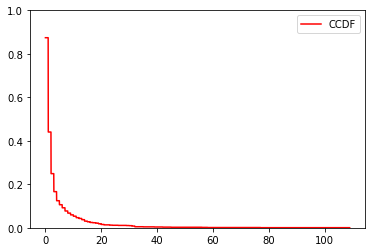

In [147]:
# getting data of the histogram
count, bins_count = np.histogram(conv_df['tree_depth'], bins=10000)
  
# finding the PDF of the histogram using count values
pdf = count / sum(count)
  
# using numpy np.cumsum to calculate the CDF
# We can also find using the PDF values by looping and adding
cdf = np.cumsum(pdf)
ccdf = 1-cdf
  
# plotting PDF and CDF
plt.plot(bins_count[1:], 1-cdf, color="red", label="CCDF")
plt.ylim(0, 1)
plt.legend()

(array([1.528e+03, 6.500e+01, 1.400e+01, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  10.9,  21.8,  32.7,  43.6,  54.5,  65.4,  76.3,  87.2,
         98.1, 109. ]),
 <BarContainer object of 10 artists>)

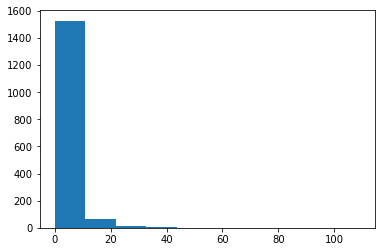

In [106]:
plt.hist(conv_df['tree_depth'])

(array([1.597e+03, 1.200e+01, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000e+00, 4.13170e+03, 8.26240e+03, 1.23931e+04, 1.65238e+04,
        2.06545e+04, 2.47852e+04, 2.89159e+04, 3.30466e+04, 3.71773e+04,
        4.13080e+04]),
 <BarContainer object of 10 artists>)

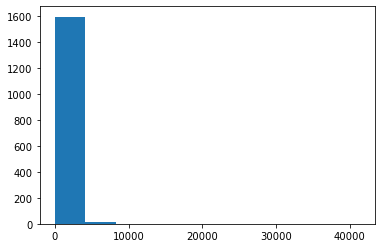

In [107]:
plt.hist(conv_df['tree_size'])

(array([1.578e+03, 2.400e+01, 5.000e+00, 3.000e+00, 0.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0.        ,  2751.83571429,  5503.67142857,  8255.50714286,
        11007.34285714, 13759.17857143, 16511.01428571, 19262.85      ,
        22014.68571429, 24766.52142857, 27518.35714286]),
 <BarContainer object of 10 artists>)

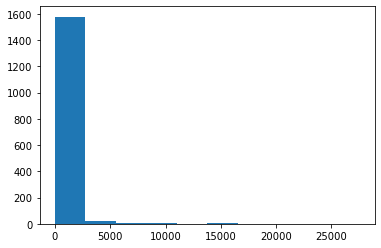

In [108]:
plt.hist(conv_df['graph_avg_user_follower_count'])

## Do Some Classification

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.inspection import permutation_importance

In [83]:
def create_train_test(conv_df, test_frac=0.25, r_seed=1):
    X = conv_df.loc[:, conv_df.columns!='y']
    y = conv_df['y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_frac, random_state=r_seed)
    
    return X_train, X_test, y_train, y_test

In [84]:
def create_param_dict(method):
    if method=='LR':
        param_dict = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
    elif method=='RF':
        param_dict = {'max_depth': [2, 5, 10, 25, 50, 100],
                      'n_estimators': [25, 50, 100, 200, 500]}
    elif method=='GB':
        param_dict = {'max_depth': [2, 5, 10, 25],
                      'n_estimators': [25, 100, 250],
                      'learning_rate': [0.01, 0.01, 0.1, 1, 10]}
    return param_dict

In [108]:
def k_fold_cv(method, param_dict, X_train, y_train, cv_splits=5, seed=1):
    if method=='LR':
        gs_cv = GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    elif method=='RF':
        gs_cv = GridSearchCV(estimator=RandomForestClassifier(),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    elif method=='GB':
        gs_cv = GridSearchCV(estimator=GradientBoostingClassifier(),
                             param_grid=param_dict,
                             cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed),
                             scoring='accuracy')
        gs_cv.fit(X_train, y_train)
    
    return gs_cv

In [121]:
def model_predictions(gs_cv, X_train, y_train, X_test, y_test):
    y_hat = gs_cv.predict(X_test)
    
    accuracy = np.sum(y_hat==y_test)/len(y_test)
    f_1 = f1_score(y_test, y_hat)
    
    class_report = classification_report(y_test, y_hat, output_dict=True)
    
    precision_democrat = class_report['1.0']['precision']
    precision_republican = class_report['0.0']['precision']
    recall_democrat = class_report['1.0']['recall']
    recall_republican = class_report['0.0']['recall']
    
    return {'accuracy': accuracy, 'f_1': f_1, 'precision_democrat': precision_democrat,
            'precision_republican': precision_republican, 
            'recall_democrat': recall_democrat, 'recall_republican': recall_republican}

In [87]:
X_train, X_test, y_train, y_test = create_train_test(conv_df)
lr_param_dict = create_param_dict('LR')
rf_param_dict = create_param_dict('RF')
gb_param_dict = create_param_dict('GB')

lr_cv = k_fold_cv('LR', lr_param_dict, X_train, y_train)
print('lr done')
rf_cv = k_fold_cv('RF', rf_param_dict, X_train, y_train)
print('rf done')
gb_cv = k_fold_cv('GB', gb_param_dict, X_train, y_train)
print('gb done')

print('LR:', model_predictions(lr_cv, X_train, y_train, X_test, y_test))
print('RF:', model_predictions(rf_cv, X_train, y_train, X_test, y_test))
print('GB:', model_predictions(gb_cv, X_train, y_train, X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........................C=0.0001;, score=0.718 total time=   0.2s
[CV 2/5] END ..........................C=0.0001;, score=0.747 total time=   0.2s
[CV 3/5] END ..........................C=0.0001;, score=0.684 total time=   0.4s
[CV 4/5] END ..........................C=0.0001;, score=0.775 total time=   0.3s
[CV 5/5] END ..........................C=0.0001;, score=0.750 total time=   0.8s
[CV 1/5] END ...........................C=0.001;, score=0.731 total time=   0.6s
[CV 2/5] END ...........................C=0.001;, score=0.759 total time=   0.8s
[CV 3/5] END ...........................C=0.001;, score=0.684 total time=   0.4s
[CV 4/5] END ...........................C=0.001;, score=0.779 total time=   0.3s
[CV 5/5] END ...........................C=0.001;, score=0.750 total time=   0.3s
[CV 1/5] END ............................C=0.01;, score=0.731 total time=   0.4s
[CV 2/5] END ............................C=0.01;,

[CV 1/5] END ....max_depth=10, n_estimators=500;, score=0.869 total time=   1.6s
[CV 2/5] END ....max_depth=10, n_estimators=500;, score=0.849 total time=   1.4s
[CV 3/5] END ....max_depth=10, n_estimators=500;, score=0.820 total time=   1.4s
[CV 4/5] END ....max_depth=10, n_estimators=500;, score=0.844 total time=   1.5s
[CV 5/5] END ....max_depth=10, n_estimators=500;, score=0.852 total time=   1.5s
[CV 1/5] END .....max_depth=25, n_estimators=25;, score=0.853 total time=   0.0s
[CV 2/5] END .....max_depth=25, n_estimators=25;, score=0.849 total time=   0.0s
[CV 3/5] END .....max_depth=25, n_estimators=25;, score=0.836 total time=   0.0s
[CV 4/5] END .....max_depth=25, n_estimators=25;, score=0.824 total time=   0.0s
[CV 5/5] END .....max_depth=25, n_estimators=25;, score=0.816 total time=   0.0s
[CV 1/5] END .....max_depth=25, n_estimators=50;, score=0.869 total time=   0.1s
[CV 2/5] END .....max_depth=25, n_estimators=50;, score=0.845 total time=   0.1s
[CV 3/5] END .....max_depth=

[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=25;, score=0.762 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=25;, score=0.754 total time=   0.1s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.816 total time=   0.8s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.845 total time=   0.8s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.824 total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.799 total time=   0.8s
[CV 5/5] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.832 total time=   0.8s
[CV 1/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.857 total time=   2.1s
[CV 2/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.869 total time=   2.4s
[CV 3/5] END learning_rate=0.01, max_depth=5, n_estimators=250;, score=0.832 total time=   2.1s
[CV 4/5] END learning_rate=0.01, max_depth

[CV 5/5] END learning_rate=0.01, max_depth=10, n_estimators=250;, score=0.832 total time=   4.7s
[CV 1/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.812 total time=   0.4s
[CV 2/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.804 total time=   0.4s
[CV 3/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.811 total time=   0.4s
[CV 4/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.783 total time=   0.5s
[CV 5/5] END learning_rate=0.01, max_depth=25, n_estimators=25;, score=0.832 total time=   0.5s
[CV 1/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.820 total time=   2.0s
[CV 2/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.816 total time=   2.0s
[CV 3/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.799 total time=   2.0s
[CV 4/5] END learning_rate=0.01, max_depth=25, n_estimators=100;, score=0.791 total time=   2.0s
[CV 5/5] END learning_rate=0.01, ma

[CV 2/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.890 total time=   0.9s
[CV 3/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.910 total time=   1.0s
[CV 4/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.914 total time=   0.9s
[CV 5/5] END learning_rate=1, max_depth=2, n_estimators=250;, score=0.910 total time=   0.9s
[CV 1/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.890 total time=   0.2s
[CV 2/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.886 total time=   0.1s
[CV 3/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.844 total time=   0.1s
[CV 4/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.869 total time=   0.1s
[CV 5/5] END learning_rate=1, max_depth=5, n_estimators=25;, score=0.885 total time=   0.1s
[CV 1/5] END learning_rate=1, max_depth=5, n_estimators=100;, score=0.922 total time=   0.8s
[CV 2/5] END learning_rate=1, max_depth=5, n_estimators=100;, score=0.914 t

[CV 5/5] END learning_rate=10, max_depth=10, n_estimators=100;, score=0.803 total time=   1.8s
[CV 1/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.820 total time=   2.3s
[CV 2/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.771 total time=   4.9s
[CV 3/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.779 total time=   1.8s
[CV 4/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.754 total time=   4.7s
[CV 5/5] END learning_rate=10, max_depth=10, n_estimators=250;, score=0.775 total time=   4.6s
[CV 1/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.796 total time=   0.5s
[CV 2/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.812 total time=   0.4s
[CV 3/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.779 total time=   0.4s
[CV 4/5] END learning_rate=10, max_depth=25, n_estimators=25;, score=0.787 total time=   0.4s
[CV 5/5] END learning_rate=10, max_depth=25, n_estimat

In [152]:
gb_cv.best_params_

{'learning_rate': 1, 'max_depth': 5, 'n_estimators': 250}

In [153]:
gb_clf = GradientBoostingClassifier(learning_rate=1, max_depth=5, n_estimators=250)
gb_clf.fit(X_train, y_train)

In [170]:
feature_imp_dict = {}
feat_imp_vec = gb_clf.feature_importances_
for j in range(len(X_train.columns)):
    feature_imp_dict[X_train.columns[j]] = feat_imp_vec[j]
feature_imp_sort = dict(sorted(feature_imp_dict.items(), key=lambda item: item[1], reverse=True))

top_6_features = []
for col_name, importance in feature_imp_sort.items():
    top_6_features.append(col_name)
    if len(top_6_features)==6:
        break

print(top_6_features)

['graph_avg_user_tweet_count', 'graph_author_tweet_count', 'graph_author_listed_count', 'graph_author_following_count', 'graph_author_follower_count', 'tree_breadth']


### Plot Distributions of top features